In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np
import math

## Multiresolution Hash encoding

In nerf-ngp they show that hash encoding is allowing us to speed up conversion of nerf model.  
Here we will take apart multiresolution hash encoding and see how it works from inside, and implement our own encoding class.

In [2]:
# Our dummy input represents one point in [near, far] bounding space
# dummy_input = torch.tensor([[-1., -2., 3]]) # 3D
dummy_input = torch.tensor([[-1., 3.]]) # 2D

# Normalizing our input by bounding distance
far=6
near=2
bound_distance = far - near

norm_dummy_input = (bound_distance - dummy_input) / (2 * bound_distance)
print(norm_dummy_input)


tensor([[0.6250, 0.1250]])


We will separate this encoding on next parts:  
-  Generating hash table
- Writing HashGridEncoding class

### Generating hash table

In [3]:
# Here we define parameters for our future enncoding

# Theoreticly we can encode as many dimentions as many primes we have
PRIMES = [1, 2654435761, 805459861, 3674653429, 2097192037, 1434869437, 2165219737]

# Number of different resolution levels,
# each one will have finer grid 
n_levels = 3

# Maximum and minimum resulutions for levels
coarsest_resolution = 16
finest_resolution = 512 # from 512 to 524288

# Number of feature dimensions per one data point
# For 2D is 2; For 3D is 3; and so on... ???
n_dim_per_resolution = 2

# Max hash table size for each level 
max_entries_per_level = 2**14 # from 2^14 to 2^24


In [4]:
# First we compute resolutions for each level
# This is geometric progression between 
# coarsest_resolution and finest_resolution

resolutions = []

b = math.log(finest_resolution) - math.log(coarsest_resolution)

for level in range(1, n_levels+1):
    b_factor = math.floor(math.exp(b / (level)))
    level_resolution = coarsest_resolution * b_factor
    resolutions.append(level_resolution)
resolutions

[512, 80, 48]

In [5]:
def get_box_corners_2d(inputs, coarsest_resolution):
    box_index = inputs // coarsest_resolution
    box_coordinates_1 = box_index[0] * coarsest_resolution
    box_coordinates_2 = box_index[0] * coarsest_resolution+coarsest_resolution
    
    coordinates = [
        [box_coordinates_1[0], box_coordinates_1[1]],
        [box_coordinates_2[0], box_coordinates_2[1]],
        [box_coordinates_1[0], box_coordinates_2[1]],
        [box_coordinates_2[0], box_coordinates_1[1]]
    ]
    return np.array(coordinates).astype(int)



512 [[240 496]
 [256 512]
 [240 512]
 [256 496]]


/home/ivan/miniconda3/envs/dnerf/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  


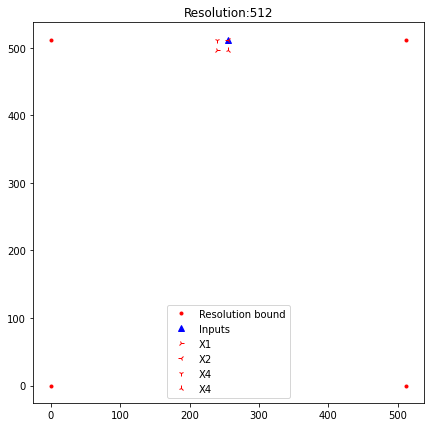

80 [[32 64]
 [48 80]
 [32 80]
 [48 64]]


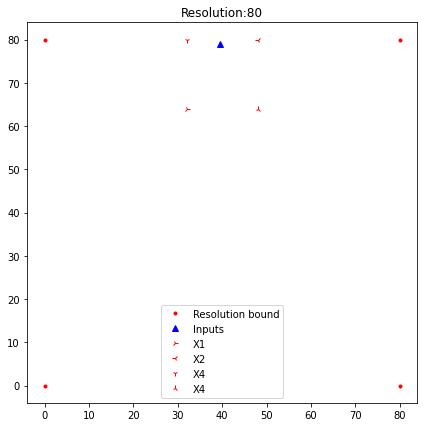

48 [[16 32]
 [32 48]
 [16 48]
 [32 32]]


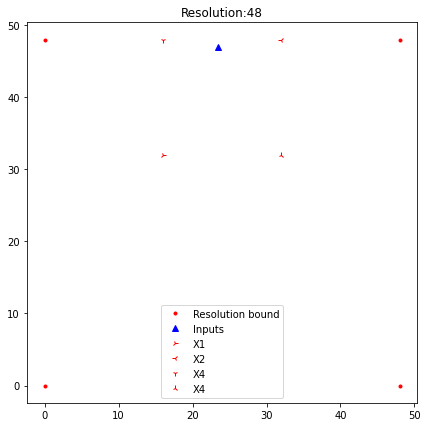

In [6]:
# Imagene we have a test 2D input
# we go through every resolution we have
# and finding corner coordinated of a box that surraunds input.
# See get_box_corners_2d() 

test_input = torch.tensor([[0.5,1.]])

for resolution in resolutions:
    # LOGIC
    inputs = test_input * (resolution-1)
    coords = get_box_corners_2d(inputs, coarsest_resolution)
    print(resolution, coords)
    # PLOTTING
    fig, ax = plt.subplots(figsize=(7,7))
    ax.set_title('Resolution:'+str(resolution))

    # Plot resolution box
    ax.plot([0,0,resolution,resolution], [0,resolution,0,resolution], 'r.',
    label='Resolution bound')

    # Input
    ax.plot(inputs[0,0], inputs[0,1], 'b^', label='Inputs')

    ax.plot(coords[0,0], coords[0,1], 'r4', label='X1')
    ax.plot(coords[1,0], coords[1,1], 'r3', label='X2')
    ax.plot(coords[2,0], coords[2,1], 'r1', label='X4')
    ax.plot(coords[3,0], coords[3,1], 'r2', label='X4')

    plt.legend()
    plt.show()
    

In [7]:
def get_box_corners_3d(inputs, coarsest_resolution):
    box_index = inputs // coarsest_resolution
    c1 = box_index[0] * coarsest_resolution
    c2 = box_index[0] * coarsest_resolution+coarsest_resolution
    
    coordinates = [
        # Top square
        [c1[0], c1[1], c2[2]],
        [c2[0], c2[1], c2[2]],
        [c1[0], c2[1], c2[2]],
        [c2[0], c1[1], c2[2]],
        # Bottom square
        [c1[0], c1[1], c1[2]],
        [c2[0], c2[1], c1[2]],
        [c1[0], c2[1], c1[2]],
        [c2[0], c1[1], c1[2]],
    ]
    return np.array(coordinates).astype(int)



/home/ivan/miniconda3/envs/dnerf/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  


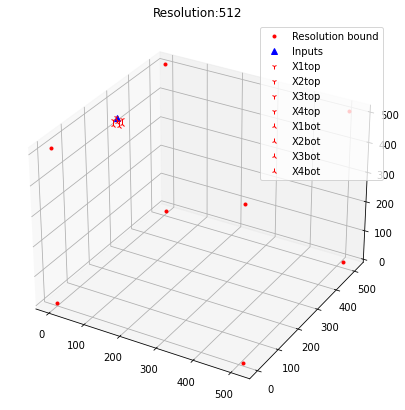

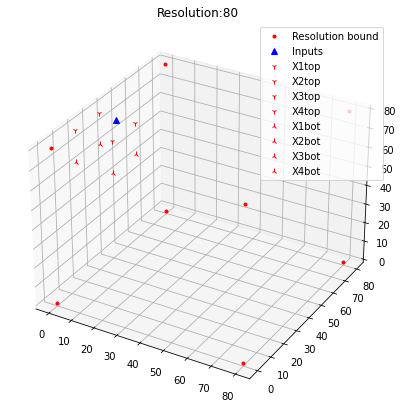

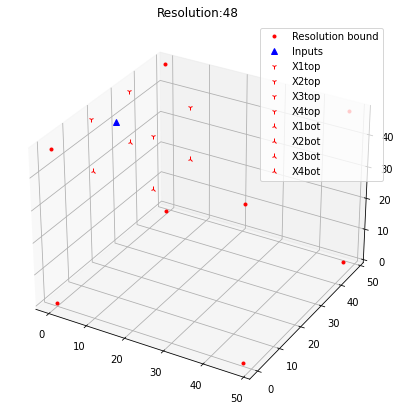

In [8]:
# Imagene we have a test 3D input
# we go through every resolution we have
# and finding corner coordinated of a box that surraunds input.
# See get_box_corners_2d() 

test_input = torch.tensor([[0.1,0.4, 1.0]])

for resolution in resolutions:
    # LOGIC
    inputs = test_input * (resolution-1)
    
    
    c = get_box_corners_3d(inputs, coarsest_resolution)

    # PLOTTING
    fig = plt.figure(figsize=(7,7))
    ax = fig.add_subplot(projection='3d')
    ax.set_title('Resolution:'+str(resolution))

    # Plot resolution box
    ax.plot(
        [0,0,0,0,resolution,resolution,resolution,resolution], 
        [0,resolution,0,resolution,0,resolution,0,resolution],
        [0,0,resolution,resolution,0,0,resolution,resolution],
        'r.',
        label='Resolution bound')

    # Input
    ax.plot(
        inputs[0,0], 
        inputs[0,1],
        inputs[0,2],
        'b^', 
        label='Inputs')

    ax.plot(c[0,0], c[0,1], c[0,2], 'r1', label='X1top')
    ax.plot(c[1,0], c[1,1], c[1,2], 'r1', label='X2top')
    ax.plot(c[2,0], c[2,1], c[2,2], 'r1', label='X3top')
    ax.plot(c[3,0], c[3,1], c[3,2], 'r1', label='X4top')

    ax.plot(c[4,0], c[4,1], c[4,2], 'r2', label='X1bot')
    ax.plot(c[5,0], c[5,1], c[5,2], 'r2', label='X2bot')
    ax.plot(c[6,0], c[6,1], c[6,2], 'r2', label='X3bot')
    ax.plot(c[7,0], c[7,1], c[7,2], 'r2', label='X4bot')

    plt.legend()
    plt.show()
    

In [9]:
# Making parametric hash table
# that will contain embeddings for each corner of hypercube
# Our text encoding will be just arange form 1 to table_size

# 1
hash_table = []#nn.ParameterList([])
for resolution in resolutions:
    total_resolution = resolution ** n_dim_per_resolution
    table_size = int(min(total_resolution, max_entries_per_level))
    table = torch.zeros((table_size, n_dim_per_resolution))
    table = torch.range(0,table.shape[0]+1).repeat(2,1).T
    # table = nn.Parameter(table)
    hash_table.append(table)
# hash_table


/home/ivan/miniconda3/envs/dnerf/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  # This is added back by InteractiveShellApp.init_path()


In [10]:
test_input = torch.tensor([[0.5,1.]])

for level, resolution in enumerate(resolutions):
    # LOGIC
    inputs = test_input * (resolution-1)
    corners_coords = get_box_corners_2d(inputs, coarsest_resolution)

    # print(inputs, coords)

    # HASH
    _sum = 0
    for i in range(n_dim_per_resolution):
        _sum = _sum ^ (corners_coords[..., i] * PRIMES[i])
        print(_sum)
    index = _sum % max_entries_per_level
    index = torch.tensor(index).to(torch.long).flatten()

    # Get Hash features
    level_hash_table = hash_table[level]
    corners_features = level_hash_table[index]

    


    break


[240 256 240 256]
[1316600137216 1359071109888 1359071109872 1316600137712]


/home/ivan/miniconda3/envs/dnerf/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  


In [11]:
level_hash_table[index]

tensor([[1536., 1536.],
        [8960., 8960.],
        [8944., 8944.],
        [2032., 2032.]])

In [13]:
# corners_coords.shape
# corners_features.reshape(
#     corners_coords.shape[0], 
#     corners_coords.shape[1],
#     n_dim_per_resolution)


In [14]:
# torch.reshape(self.hashtable[lvl][flat_feature_index],
# (corners.shape[0], corners.shape[1], self.feature_dim))
# weights = self.interpolation_weights(coord - floor_corner)